In [2]:
!pip install metpy
!pip install geopandas

     |████████████████████████████████| 327kB 6.7MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 215kB 16.9MB/s 
     |████████████████████████████████| 972kB 6.9MB/s 
     |████████████████████████████████| 14.8MB 321kB/s 
     |████████████████████████████████| 6.5MB 39.8MB/s 


In [3]:
import pandas as pd
import metpy
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt
import geopandas as gpd

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in miles. Use 6371 for kilometers
    return c * r

In [201]:
stations_inventory = pd.read_csv('https://www1.ncdc.noaa.gov/pub/data/noaa/isd-inventory.csv',dtype='str')
stations_list = pd.read_csv('https://www1.ncdc.noaa.gov/pub/data/noaa/isd-history.csv',dtype='str')
stations_list['STATION NAME'] = stations_list['STATION NAME'].astype(str)

In [203]:
# stations_list[stations_list['USAF']==718920]
stations_list[stations_list['STATION NAME'].str.contains('VANCOUVER', regex=False)]
# mask = stations_list['STATION NAME'].str.contains('VAN')


,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
15860,712010,99999,VANCOUVER HARBOUR CS BC,CA,NaN,CWHC,+49.283,-123.117,+0003.0,19800301,20201206
15861,712013,99999,VANCOUVER INTL,CA,NaN,WHC,+49.183,-123.167,+0003.0,19880105,19881208
16351,716080,99999,VANCOUVER SEA ISLAND CCG,CA,NaN,CVVR,+49.183,-123.183,+0002.1,19820102,20201206
16587,717840,99999,WEST VANCOUVER (AUT),CA,NaN,CWWA,+49.350,-123.200,+0168.0,19950423,20201206
16831,718920,99999,VANCOUVER INTL,CA,NaN,CYVR,+49.194,-123.184,+0004.3,19550702,20201206
16832,718925,99999,VANCOUVER HARBOUR,CA,NaN,NaN,+49.300,-123.117,+0005.0,19770701,19800227
16833,718926,99999,VANCOUVER HARBOUR &,CA,NaN,YHC,+49.300,-123.117,+0005.0,19790131,19790604
21296,728920,99999,VANCOUVER INTL,CA,NaN,NaN,+49.183,-123.167,+0003.0,19730101,19770630
21297,728925,99999,VANCOUVER HARBOUR &,CA,NaN,NaN,+49.300,-123.117,+0005.0,19760212,19770630


In [175]:
ds = pd.DataFrame()
ds['station'] = stations_list['STATION NAME']
ds['begin'] = pd.to_datetime(stations_list['BEGIN'], format='%Y%m%d')
ds['end'] = pd.to_datetime(stations_list['END'], format='%Y%m%d')
ds['latitude'] = stations_list['LAT']
ds['longitude'] = stations_list['LON']

start = pd.Timestamp(1975,12,31)
end = pd.Timestamp(2005,12,31)

ds = ds[ds['begin'] < start]
ds = ds[ds['end'] > end]

gdf = gpd.GeoDataFrame(
    ds, geometry=gpd.points_from_xy(
        ds.longitude, ds.latitude)).set_crs(epsg=3857)

gdf['distance'] = gdf['geometry'].apply(lambda x : haversine(x.x,
                                                              x.y,
                                                              -123.177,
                                                              49.283))
match = stations_list[stations_list.index==
                      gdf[gdf['distance']==gdf['distance'].min()]['station'].index.values[0]]
usaf = match['USAF'].values[0]
wban = match['WBAN'].values[0]
ext = str(usaf)+str(wban)
print(gdf[gdf['distance']==gdf['distance'].min()]['station'].values[0])
print(ext)

VANCOUVER INTL
71892099999


In [261]:
r = 'https://www.ncei.noaa.gov/data/global-hourly/access/1976/71892099999.csv'

from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError
allweather = pd.DataFrame()
missingyears = []
yearrange = range(1976-3,2005+3,1)
ext = 71892099999
for year in yearrange:
  print(year)
  url = 'https://www.ncei.noaa.gov/data/global-hourly/access/{y}/{e}.csv'.format(y=year,e=ext)
  req = Request(url)
  try:
      response = urlopen(req)
  except HTTPError as e:
      print('For '+str(year)+' the server couldn\'t fulfill the request.')
      # print('Error code: ', e.code)
      missingyears.append(year)
  except URLError as e:
      print('For '+str(year)+' the server couldn\'t fulfill the request.')
      # print('Reason: ', e.reason)
      missingyears.append(year)
      continue
  else:
      df = pd.read_csv(url)
      allweather = allweather.append(df,ignore_index=True)
      print('Website is working fine. Adding data to the dataframe.')

1973
For 1973 the server couldn't fulfill the request.
1974
For 1974 the server couldn't fulfill the request.
1975
For 1975 the server couldn't fulfill the request.
1976
For 1976 the server couldn't fulfill the request.
1977
Website is working fine. Adding data to the dataframe.
1978
Website is working fine. Adding data to the dataframe.
1979
Website is working fine. Adding data to the dataframe.
1980
Website is working fine. Adding data to the dataframe.
1981
Website is working fine. Adding data to the dataframe.
1982
Website is working fine. Adding data to the dataframe.
1983
Website is working fine. Adding data to the dataframe.
1984
Website is working fine. Adding data to the dataframe.
1985
Website is working fine. Adding data to the dataframe.
1986
Website is working fine. Adding data to the dataframe.
1987
Website is working fine. Adding data to the dataframe.
1988
Website is working fine. Adding data to the dataframe.
1989
Website is working fine. Adding data to the dataframe.


In [262]:
df=allweather
wind = df.WND.str.split(pat=',',expand=True).set_index(df.DATE).rename(columns={0:'wind_dir',
                                                                            1:'wind_dirqc',
                                                                            2:'wind_type',
                                                                            3:'wind_spd',
                                                                            4:'wind_spdqc'})

sky = df.CIG.str.split(pat=',',expand=True).set_index(df.DATE).rename(columns={0:'sky_clg',
                                                                               1:'sky_clgqc',
                                                                               2:'sky_clgmethod',
                                                                               3:'sky_cavok'})

vis = df.VIS.str.split(pat=',',expand=True).set_index(df.DATE).rename(columns={0:'vis_dist',
                                                                               1:'vis_distqc',
                                                                               2:'vis_variable',
                                                                               3:'vis_variableqc'})

temp = df.TMP.str.split(pat=',',expand=True).set_index(df.DATE).rename(columns={0:'temp_cels',
                                                                               1:'temp_cels_qc'})

dew = df.DEW.str.split(pat=',',expand=True).set_index(df.DATE).rename(columns={0:'dew_temp',
                                                                               1:'dew_tempqc'})

psl = df.SLP.str.split(pat=',',expand=True).set_index(df.DATE).rename(columns={0:'psl_hpscal',
                                                                               1:'psl_hpscalqc'})


# datetime.strptime(d, "%Y-%m-%dT%H:%M:%S%z"
dfall = pd.concat([wind,sky,vis,temp,dew,psl],axis=1)
dfall = dfall.replace(['999','9','9999','99999','999999'],np.nan)
dfall.index = pd.to_datetime(dfall.index)#, "%Y-%m-%dT%H:%M:%S")
del dfall['wind_type']
del dfall['sky_clgmethod']
del dfall['sky_cavok']
del dfall['vis_variable']

def check(x):
  if '+' in x:
    x.replace('+','')
    x = float(x)/10
  elif '-' in x:
    x.replace('-','')
    x = float(x)*-1
    x = x/10
  else:
    x = x/10
  if x>100 or x<-100:
    x = np.nan
  else:
    x=x
  return x

dfall['temp_cels'] = dfall.apply(lambda x: check(x['temp_cels']), axis=1)
dfall['dew_temp'] = dfall.apply(lambda x: check(x['dew_temp']), axis=1)

dfall = dfall.fillna(method='bfill').fillna(method='ffill').astype(float)
dfall['wind_spd'] = dfall['wind_spd']/10
dfall['psl_hpscal'] = dfall['psl_hpscal']/10
dfobs = dfall[['wind_dir','wind_spd','sky_clg',
               'temp_cels','dew_temp','psl_hpscal']].resample('1H').mean()
def rhcalc(temp,dew): #magnus approximation
  return 100*(np.exp((17.625*dew)/(243.04+dew))/np.exp((17.625*temp)/(243.04+temp)))

dfobs['hurs'] = dfobs.apply(lambda x: rhcalc(x['temp_cels'],x['dew_temp']),axis=1)
dfobs = dfobs.round(1)
dfobs.head()

,wind_dir,wind_spd,sky_clg,temp_cels,dew_temp,psl_hpscal,hurs
DATE,,,,,,,
1977-07-01 00:00:00,240.0,2.5,22000.0,21.0,11.0,1016.4,52.8
1977-07-01 01:00:00,230.0,1.0,22000.0,22.0,13.0,1015.2,56.7
1977-07-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1977-07-01 03:00:00,170.0,0.0,9000.0,21.0,14.0,1013.9,64.3
1977-07-01 04:00:00,170.0,0.0,22000.0,21.0,11.0,1013.2,52.8


KeyError: ignored

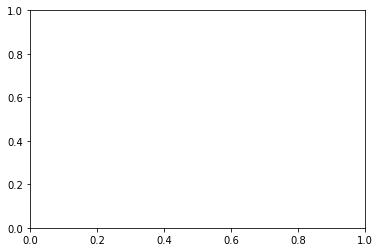

In [268]:
dfobs['date'] = dfobs.index
ax1 = dfobs.plot.scatter(x='date',
                      y='temp_cels',
                      c='DarkBlue')

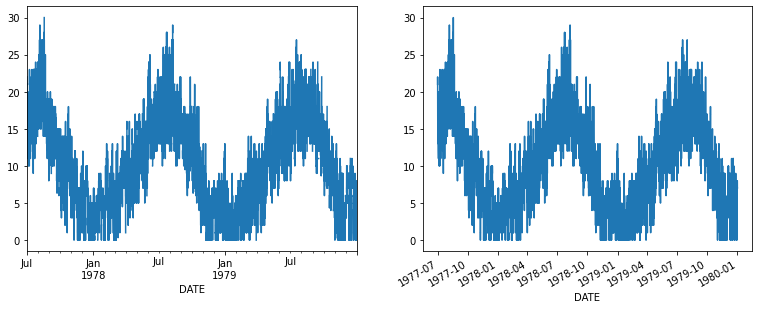

In [257]:
fig, axs = plt.subplots(1,2,figsize=[13,5])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
dfall.resample('1H').mean()['temp_cels'].plot(ax=axs[0])
dfall['temp_cels'].plot(ax=axs[1])

# The CDO API

Not really helpful in this situation but will come back to it one day.

In [288]:
key='DQLkuhyyGAKzyOQlazgSgZLKqawRaQKj'

url = 'http://www.ncdc.noaa.gov/cdo-web/api/v2/datasets/NORMAL_MLY?stationid=COOP:718920'

import requests

headers = {
    'token': key,
}

response = requests.get(url, headers=headers)

In [289]:
response.json()

{'datacoverage': 1,
 'id': 'NORMAL_MLY',
 'maxdate': '2010-12-01',
 'mindate': '2010-01-01',
 'name': 'Normals Monthly'}